# Predicting County-Level Acute Food Insecurity in Kenya  
### Capstone Project  

**Student:** shem 

---

## Project Overview

This project aims to predict whether a county in Kenya will reach **IPC Phase 3+ (Crisis or worse)** using:

-  Climate indicators (rainfall)
-  Market indicators (food prices)
-  Conflict indicators (ACLED events)
-  Structural vulnerability (MPI)

Current IPC reports describe past conditions.  
This project attempts to build a **simple early-warning model** to support proactive humanitarian response.

---

## Stakeholder Scenario

County governments and NGOs could use monthly predictions to:

- Pre-position food aid  
- Allocate emergency budgets  
- Prioritize high-risk counties  

The goal is not perfection  but **probabilistic early warning**.

# 1. Business Understanding

## Problem

IPC assessments are descriptive and retrospective.  
Humanitarian response is often reactive.

We aim to predict whether a county will reach IPC Phase 3+ using leading indicators.

---

## Why This Matters

False Negative (missed crisis) → Delayed aid  
False Positive (false alarm) → Extra allocation  

We prioritize **recall** to minimize missed crises.

---

## Modeling Objective

Binary classification problem:

Target:
- 1 = IPC Phase 3+  
- 0 = Otherwise  

Unit of analysis:
- County-month observations  

Scope:
- All 47 counties (subject to data availability)

In [1]:
# ================================
# Core Libraries
# ================================

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Advanced model
from xgboost import XGBClassifier

# Display settings
pd.set_option("display.max_columns", None)

print("Libraries successfully loaded.")

Libraries successfully loaded.


In [2]:
# Official Kenya counties list
kenya_counties = [
    "Baringo","Bomet","Bungoma","Busia","Elgeyo-Marakwet","Embu","Garissa","Homa Bay",
    "Isiolo","Kajiado","Kakamega","Kericho","Kiambu","Kilifi","Kirinyaga","Kisii","Kisumu",
    "Kitui","Kwale","Laikipia","Lamu","Machakos","Makueni","Mandera","Marsabit","Meru",
    "Migori","Mombasa","Murang'a","Nairobi","Nakuru","Nandi","Narok","Nyamira","Nyandarua",
    "Nyeri","Samburu","Siaya","Taita Taveta","Tana River","Tharaka-Nithi","Trans Nzoia",
    "Turkana","Uasin Gishu","Vihiga","Wajir","West Pokot"
]

# Expanded mapping dictionary to handle variants and settlements
county_mapping = {
    "Baringo": "Baringo",
    "Bomet": "Bomet",
    "Bungoma": "Bungoma",
    "Busia": "Busia",
    "Elgeyo-Marakwet": "Elgeyo-Marakwet",
    "Embu": "Embu",
    "Garissa": "Garissa",
    "Ijara": "Garissa",       # legacy
    "Homa Bay": "Homa Bay",
    "Isiolo": "Isiolo",
    "Kajiado": "Kajiado",
    "Kakamega": "Kakamega",
    "Kericho": "Kericho",
    "Kiambu": "Kiambu",
    "Kilifi": "Kilifi",
    "Kirinyaga": "Kirinyaga",
    "Kisii": "Kisii",
    "Kisumu": "Kisumu",
    "Kitui": "Kitui",
    "Kwale": "Kwale",
    "Laikipia": "Laikipia",
    "Lamu": "Lamu",
    "Machakos": "Machakos",
    "Makueni": "Makueni",
    "Mandera": "Mandera",
    "Marsabit": "Marsabit",
    "Moyale": "Marsabit",     # legacy
    "Meru": "Meru",
    "Meru North": "Meru",     # legacy
    "Meru South": "Meru",     # legacy
    "Migori": "Migori",
    "Mombasa": "Mombasa",
    "Murang'a": "Murang'a",
    "Nairobi": "Nairobi",
    "Nakuru": "Nakuru",
    "Nandi": "Nandi",
    "Narok": "Narok",
    "Nyamira": "Nyamira",
    "Nyandarua": "Nyandarua",
    "Nyeri": "Nyeri",
    "Samburu": "Samburu",
    "Siaya": "Siaya",
    "Taita Taveta": "Taita Taveta",
    "Tana River": "Tana River",
    "Tharaka-Nithi": "Tharaka-Nithi",
    "Trans Nzoia": "Trans Nzoia",
    "Turkana": "Turkana",
    "Uasin Gishu": "Uasin Gishu",
    "Vihiga": "Vihiga",
    "Wajir": "Wajir",
    "West Pokot": "West Pokot",


    # Marsabit sub-counties
    "Marsabit - Moyale":"Marsabit",
    "Marsabit - Laisamis":"Marsabit",
    "Marsabit - Saku":"Marsabit",
    "Marsabit - North Horr":"Marsabit",

    # Turkana sub-counties
    "Turkana West":"Turkana",
    "Turkana South":"Turkana",
    "Turkana East-Kibish-Loima":"Turkana",
    "Turkana Central":"Turkana",
    "Turkana North":"Turkana",

    # Embu sub-county
    "Embu (Mbeere)":"Embu",

    # Elgeyo-Marakwet variants
    "Elgeyo Marakwet":"Elgeyo-Marakwet",
    "Elgeyo-Marakwet East":"Elgeyo-Marakwet",
    "Elgeyo Marakwet County":"Elgeyo-Marakwet",

    # Tana River variants
    "TANA RIVER":"Tana River",
    "Tana river":"Tana River",

    # Taita Taveta variants
    "Taita":"Taita Taveta",
    "Taita Taveta":"Taita Taveta",
    "Taita taveta":"Taita Taveta",
    "Taita-Taveta":"Taita Taveta",
    "Taita Taveta County":"Taita Taveta",

    # Tharaka variants
    "Tharaka":"Tharaka-Nithi",
    "Tharaka Nithi":"Tharaka-Nithi",
    "Tharaka-nithi":"Tharaka-Nithi",
    "Tharaka-Nithi County":"Tharaka-Nithi",

    # Lamu variants
    "Lamu County":"Lamu",
    "Lamu county":"Lamu",

    # Homabay variants
    "Homabay":"Homa Bay",
    "Homa Bay County":"Homa Bay",

    # Murang'a variants
    "Murang'A":"Murang'a",
    "Muranga":"Murang'a",
    "Murang'a County":"Murang'a",

    # West Pokot variants
    "West pokot":"West Pokot",

    # Nairobi settlements (various casing)
    "Kibra":"Nairobi","KIBRA":"Nairobi",
    "Mathare":"Nairobi","MATHARE":"Nairobi",
    "Mukuru":"Nairobi","MUKURU":"Nairobi",
    "Kondele":"Nairobi","KONDELE":"Nairobi",
    "Kangemi":"Nairobi","KANGEMI":"Nairobi",
    "Kawangware":"Nairobi","KAWANGWARE":"Nairobi",
    "Kayole":"Nairobi","KAYOLE":"Nairobi",
    "Dandora":"Nairobi","DANDORA":"Nairobi",
    "Githurai":"Nairobi","GITHURAI":"Nairobi",
    "Obunga":"Nairobi","OBUNGA":"Nairobi",

    # Mombasa settlements (various casing)
    "Bangladesh":"Mombasa","BANGLADESH":"Mombasa",
    "Mwembe Tayari":"Mombasa","MWEMBE TAYARI":"Mombasa",

    # Extra cleaning for county suffixes
    "Nairobi County":"Nairobi",
    "Mombasa County":"Mombasa",
    "Kisumu County":"Kisumu",
    "Kitui County":"Kitui",
    "Garissa County":"Garissa",
    
    # Meru sub-counties
    "Meru North": "Meru",
    "Meru South": "Meru",
    "Ijara": "Garissa",
    "Moyale": "Marsabit",

    # Full county dictionary (simplified example — expand as needed)
    "Baringo": "Baringo",
    "Garissa": "Garissa",
    "Ijara": "Garissa",       # legacy
    "Isiolo": "Isiolo",
    "Kajiado": "Kajiado",
    "Kilifi": "Kilifi",
    "Kisumu": "Kisumu",
    "Kitui": "Kitui",
    "Kwale": "Kwale",
    "Machakos": "Machakos",
    "Makueni": "Makueni",
    "Mandera": "Mandera",
    "Marsabit": "Marsabit",
    "Moyale": "Marsabit",     # legacy
    "Meru North": "Meru",     # legacy
    "Meru South": "Meru",     # legacy
    "Mombasa": "Mombasa",
    "Nairobi": "Nairobi",
    "Nakuru": "Nakuru",
    "Nyeri": "Nyeri",
    "Samburu": "Samburu",
    "Tana River": "Tana River",
    "Turkana": "Turkana",
    "Uasin Gishu": "Uasin Gishu",
    "Wajir": "Wajir",
    "West Pokot": "West Pokot",
    # … add the remaining counties here (all 47)
}


# Rainfall county code → county name mapping
county_code_map = {
    'KE001': 'Mombasa',
    'KE002': 'Kwale',
    'KE003': 'Kilifi',
    'KE004': 'Tana River',
    'KE005': 'Lamu',
    'KE006': 'Taita Taveta',
    'KE007': 'Garissa',
    'KE008': 'Wajir',
    'KE009': 'Mandera',
    'KE010': 'Marsabit',
    'KE011': 'Isiolo',
    'KE012': 'Meru',
    'KE013': 'Tharaka Nithi',
    'KE014': 'Embu',
    'KE015': 'Kitui',
    'KE016': 'Machakos',
    'KE017': 'Makueni',
    'KE018': 'Nyandarua',
    'KE019': 'Nyeri',
    'KE020': 'Kirinyaga',
    'KE021': 'Murang\'a',
    'KE022': 'Kiambu',
    'KE023': 'Turkana',
    'KE024': 'West Pokot',
    'KE025': 'Samburu',
    'KE026': 'Trans Nzoia',
    'KE027': 'Uasin Gishu',
    'KE028': 'Elgeyo Marakwet',
    'KE029': 'Nandi',
    'KE030': 'Baringo',
    'KE031': 'Laikipia',
    'KE032': 'Nakuru',
    'KE033': 'Narok',
    'KE034': 'Kajiado',
    'KE035': 'Kericho',
    'KE036': 'Bomet',
    'KE037': 'Kakamega',
    'KE038': 'Vihiga',
    'KE039': 'Bungoma',
    'KE040': 'Busia',
    'KE041': 'Siaya',
    'KE042': 'Kisumu',
    'KE043': 'Homa Bay',
    'KE044': 'Migori',
    'KE045': 'Kisii',
    'KE046': 'Nyamira',
    'KE047': 'Nairobi'

}

# 2. Data Understanding

This project integrates multiple open-access datasets:

1. IPC Kenya classifications → Target variable  
2. Rainfall data → Climate predictor  
3. WFP food prices → Market predictor  
4. ACLED conflict events → Conflict predictor  
5. MPI (Multidimensional Poverty Index) → Structural vulnerability  

Each dataset comes from a different source and requires harmonization.

We will carefully inspect each dataset before merging.

In [3]:
# ================================
# Load Raw Datasets
# ================================

# IPC Area data 
ipc = pd.read_csv("C:\\Users\\user\Documents\\phase5\\PHASE-5-PROJECT---PREDICTING-FOOD-INSECURITY\\data\\ipc_ken_area_long.csv")
ipc_clean = pd.read_csv("C:\\Users\\user\Documents\\phase5\\PHASE-5-PROJECT---PREDICTING-FOOD-INSECURITY\\data\\cleaned_ipc_final.csv")
# Rainfall
rainfall = pd.read_csv("C:\\Users\\user\Documents\\phase5\\PHASE-5-PROJECT---PREDICTING-FOOD-INSECURITY\\data\\ken-rainfall-subnat-full.csv")

# Food Prices
prices = pd.read_csv("C:\\Users\\user\Documents\\phase5\\PHASE-5-PROJECT---PREDICTING-FOOD-INSECURITY\\data\\wfp_food_prices_ken.csv")

# Conflict 
conflict = pd.read_excel("C:\\Users\\user\Documents\\phase5\\PHASE-5-PROJECT---PREDICTING-FOOD-INSECURITY\\data\\kenya_political_violence_events_and_fatalities_by_month-year_as-of-11feb2026.xlsx", sheet_name="Data")
conflict_clean = pd.read_csv("C:\\Users\\user\Documents\\phase5\\PHASE-5-PROJECT---PREDICTING-FOOD-INSECURITY\\data\\cleaned_conflicts.csv")   
# MPI 
mpi = pd.read_csv("C:\\Users\\user\Documents\\phase5\\PHASE-5-PROJECT---PREDICTING-FOOD-INSECURITY\\data\\ken_mpi.csv",skiprows=1)

In [4]:
# inspecting rainfall data
rainfall.head()

,date,adm_level,adm_id,PCODE,n_pixels,rfh,rfh_avg,r1h,r1h_avg,r3h,r3h_avg,rfq,r1q,r3q,version
0,1981-01-01,1,51325,KE019,427.0,7.372365,15.759407,NaN,NaN,NaN,NaN,59.598840,NaN,NaN,final
1,1981-01-11,1,51325,KE019,427.0,4.325527,19.294770,NaN,NaN,NaN,NaN,38.384920,NaN,NaN,final
2,1981-01-21,1,51325,KE019,427.0,5.569087,16.265417,17.266980,51.319595,NaN,NaN,49.700817,39.536823,NaN,final
3,1981-02-01,1,51325,KE019,427.0,5.882904,12.719282,15.777517,48.279470,NaN,NaN,61.418427,38.997230,NaN,final
4,1981-02-11,1,51325,KE019,427.0,17.180328,18.768618,28.632318,47.753320,NaN,NaN,93.317700,63.753933,NaN,final


In [5]:
# checking rainfall columns
rainfall['adm_level'].value_counts()
rainfall['PCODE'].str.len().value_counts()
rainfall['PCODE'].nunique()

81

In [6]:
# inspecting the "cleaned" ipc data
print(ipc_clean.head())
print(ipc_clean.dtypes)
print(ipc_clean.shape)

print(conflict_clean.head())
print(conflict_clean.dtypes)
print(conflict_clean.shape)

   Unnamed: 0   County    Month       IPC  in_Phase3+
0           0  Baringo  2011-01  1.500000           0
1           1  Baringo  2011-04  1.500000           0
2           2  Baringo  2011-07  1.739130           1
3           3  Baringo  2011-10  1.826087           1
4           4  Baringo  2012-01  1.739130           0
Unnamed: 0      int64
County         object
Month          object
IPC           float64
in_Phase3+      int64
dtype: object
(2250, 5)
     Month           County  Fatalities  Events
0  2015-01          Baringo         1.0     1.0
1  2015-01            Bomet         0.0     2.0
2  2015-01          Bungoma         1.0     1.0
3  2015-01            Busia         0.0     1.0
4  2015-01  Elgeyo Marakwet         0.0     0.0
Month          object
County         object
Fatalities    float64
Events        float64
dtype: object
(6204, 4)


In [7]:
# Check shapes
print("IPC shape:", ipc.shape)
print("MPI shape:", mpi.shape)
print("Rain shape:", rainfall.shape)
print("Conflict shape:", conflict.shape)
print("Prices shape:", prices.shape)

IPC shape: (4522, 11)
MPI shape: (48, 11)
Rain shape: (131544, 15)
Conflict shape: (350, 5)
Prices shape: (17365, 16)


In [8]:
# 1. Drop useless columns
ipc_clean = ipc_clean.drop(columns=['Unnamed: 0'], errors='ignore')

# 2. Convert Month to datetime
ipc_clean['Month'] = pd.to_datetime(ipc_clean['Month'])

# 3. Strip County names
ipc_clean['County'] = ipc_clean['County'].str.strip()

# 4. Inspect
ipc_clean.head()
ipc_clean.dtypes
ipc_clean.shape
ipc_clean.isna().sum()

County        0
Month         0
IPC           0
in_Phase3+    0
dtype: int64

In [9]:
# Convert Month to datetime
conflict_clean['Month'] = pd.to_datetime(conflict_clean['Month'])

# Strip County names
conflict_clean['County'] = conflict_clean['County'].str.strip()

# Inspect
conflict_clean.head()
conflict_clean.dtypes
conflict_clean.shape
conflict_clean.isna().sum()

Month         0
County        0
Fatalities    0
Events        0
dtype: int64

In [10]:
print("IPC range:", ipc_clean['Month'].min(), "to", ipc_clean['Month'].max())
print("Conflict range:", conflict_clean['Month'].min(), "to", conflict_clean['Month'].max())

IPC range: 2011-01-01 00:00:00 to 2025-10-01 00:00:00
Conflict range: 2015-01-01 00:00:00 to 2025-12-01 00:00:00


### Time Coverage Assessment

IPC data spans:
- January 2011 to October 2025

Conflict data spans:
- January 2015 to December 2025

The overlapping window is therefore:

**January 2015 – October 2025**

Also IPC phases typically remain constant throughout a quarter, the standard approach is to forward-fill (ffill) the values for the missing months.



In [11]:
ipc_clean = ipc_clean[
    ipc_clean['Month'] >= conflict_clean['Month'].min()
].copy()

ipc_clean['Month'].min(), ipc_clean['Month'].max(), ipc_clean.shape

(Timestamp('2015-01-01 00:00:00'), Timestamp('2025-10-01 00:00:00'), (1558, 4))

In [12]:
# 1. Ensure the Date column is converted to datetime objects
ipc_clean['Month'] = pd.to_datetime(ipc_clean['Month'])

# 2. Set the 'Date' column as the index (crucial for resample)
ipc_clean = ipc_clean.set_index('Month')

# 3. Perform the groupby and resample
ipc_clean = ipc_clean.groupby('County').resample('MS').ffill().reset_index(level=0, drop=True).reset_index()



In [13]:
ipc_clean.head()

,Month,County,IPC,in_Phase3+
0,2015-01-01,Baringo,1.217391,0
1,2015-02-01,Baringo,1.217391,0
2,2015-03-01,Baringo,1.217391,0
3,2015-04-01,Baringo,1.130435,0
4,2015-05-01,Baringo,1.130435,0


In [14]:
conflict_clean.head()

,Month,County,Fatalities,Events
0,2015-01-01,Baringo,1.0,1.0
1,2015-01-01,Bomet,0.0,2.0
2,2015-01-01,Bungoma,1.0,1.0
3,2015-01-01,Busia,0.0,1.0
4,2015-01-01,Elgeyo Marakwet,0.0,0.0


### Merging IPC and Conflict Data

We merge the datasets using:
- County
- Month

IPC is quarterly while conflict is monthly.
Since conflict contains monthly observations, it should match
IPC months exactly for overlapping dates.

Any missing conflict values after merging will represent
months with zero recorded conflict events.

In [15]:
panel = ipc_clean.merge(
    conflict_clean,
    on=['County', 'Month'],
    how='left'
)

print(panel.shape)
panel[['Events','Fatalities']].isna().sum()

(6333, 6)


Events        370
Fatalities    370
dtype: int64

### Diagnosing Missing Conflict Observations

After merging IPC with monthly conflict data,
370 County–Month observations have missing conflict values.

These likely represent months where:
- No conflict record exists in the dataset for that county-month, OR
- That specific quarter month is not present in the conflict file.

We verify before assuming zeros.

In [16]:
panel[panel['Events'].isna()].head(10)

,Month,County,IPC,in_Phase3+,Fatalities,Events
633,2015-01-01,Elgeyo-Marakwet,1.0,0,NaN,NaN
634,2015-02-01,Elgeyo-Marakwet,1.0,0,NaN,NaN
635,2015-03-01,Elgeyo-Marakwet,1.0,0,NaN,NaN
636,2015-04-01,Elgeyo-Marakwet,1.0,0,NaN,NaN
637,2015-05-01,Elgeyo-Marakwet,1.0,0,NaN,NaN
638,2015-06-01,Elgeyo-Marakwet,1.0,0,NaN,NaN
639,2015-07-01,Elgeyo-Marakwet,1.0,0,NaN,NaN
640,2015-08-01,Elgeyo-Marakwet,1.0,0,NaN,NaN
641,2015-09-01,Elgeyo-Marakwet,1.0,0,NaN,NaN
642,2015-10-01,Elgeyo-Marakwet,1.0,0,NaN,NaN


### Investigating County Name Mismatches

Missing conflict values appear concentrated in specific counties.
This suggests inconsistencies in county naming between
IPC and conflict datasets (e.g., hyphenation or suffix differences).

We compare unique county names across both datasets.

In [17]:
ipc_counties = set(ipc_clean['County'].unique())
conf_counties = set(conflict_clean['County'].unique())

ipc_only = ipc_counties - conf_counties
conf_only = conf_counties - ipc_counties

print("In IPC but not in Conflict:")
print(ipc_only)

print("\nIn Conflict but not in IPC:")
print(conf_only)

In IPC but not in Conflict:
{'Elgeyo-Marakwet', "Murang'a", 'Kapenguria', 'Elgeyo-Marakwet East'}

In Conflict but not in IPC:
{'Muranga'}


### Standardizing County Names

To ensure proper merging:
- Sub-county names are mapped to their parent counties.
- Punctuation differences are standardized.

In [18]:
# Fix Murang'a spelling
ipc_clean['County'] = ipc_clean['County'].replace({
    "Murang'a": "Muranga"
})

# Merge sub-counties into correct counties
ipc_clean['County'] = ipc_clean['County'].replace({
    "Elgeyo-Marakwet East": "Elgeyo-Marakwet",
    "Kapenguria": "West Pokot"
})

# Standardize hyphen formatting
conflict_clean['County'] = conflict_clean['County'].replace({
    "Elgeyo Marakwet": "Elgeyo-Marakwet"
})

In [19]:
ipc_counties = set(ipc_clean['County'].unique())
conf_counties = set(conflict_clean['County'].unique())

print(ipc_counties - conf_counties)
print(conf_counties - ipc_counties)

{'Elgeyo Marakwet'}
set()


In [20]:
ipc_clean['County'] = ipc_clean['County'].replace({
    "Elgeyo Marakwet": "Elgeyo-Marakwet"
})

### Final County Name Harmonization

A final formatting inconsistency remains:
- "Elgeyo Marakwet" vs "Elgeyo-Marakwet"

We standardize both datasets to use the hyphenated version
to ensure exact merge compatibility.

In [21]:
ipc_counties = set(ipc_clean['County'].unique())
conf_counties = set(conflict_clean['County'].unique())

print(ipc_counties - conf_counties)
print(conf_counties - ipc_counties)

set()
set()


### Merging IPC and Conflict (Post-Harmonization)

After standardizing county names across datasets,
we merge IPC (quarterly county-level data)
with conflict (monthly county-level data).

The merge is performed on:
- County
- Month

Any remaining missing conflict values will represent
true zero-conflict months.

In [22]:
panel = ipc_clean.merge(
    conflict_clean,
    on=['County', 'Month'],
    how='left'
)

panel.shape
panel[['Events','Fatalities']].isna().sum()

Events        0
Fatalities    0
dtype: int64

### Final Panel Structure (IPC + Conflict)

The merged dataset contains:

- County-level quarterly IPC outcomes
- Monthly conflict variables aligned to IPC months
- No missing values in conflict variables
- Time coverage: January 2015 – October 2025

The dataset is now structurally balanced and ready
for feature engineering (lag creation).

In [23]:
panel.head()
panel.shape
panel.dtypes
panel.isna().sum()

Month         0
County        0
IPC           0
in_Phase3+    0
Fatalities    0
Events        0
dtype: int64

### Creating Lagged Conflict Variables

Food insecurity does not respond instantaneously to shocks.
To capture delayed effects, we construct 1-period lags of:

- Events
- Fatalities

Lags are computed within each county to preserve panel structure.

In [24]:
# Sort properly first
panel = panel.sort_values(['County', 'Month'])

# Create 1-period lag within county
panel['Events_lag1'] = panel.groupby('County')['Events'].shift(1)
panel['Fatalities_lag1'] = panel.groupby('County')['Fatalities'].shift(1)

panel[['Events_lag1','Fatalities_lag1']].isna().sum()

Events_lag1        47
Fatalities_lag1    47
dtype: int64

In [25]:
panel.head(20)

,Month,County,IPC,in_Phase3+,Fatalities,Events,Events_lag1,Fatalities_lag1
0,2015-01-01,Baringo,1.217391,0,1.0,1.0,NaN,NaN
1,2015-02-01,Baringo,1.217391,0,1.0,1.0,1.0,1.0
2,2015-03-01,Baringo,1.217391,0,0.0,1.0,1.0,1.0
3,2015-04-01,Baringo,1.130435,0,1.0,1.0,1.0,0.0
4,2015-05-01,Baringo,1.130435,0,54.0,3.0,1.0,1.0
5,2015-06-01,Baringo,1.130435,0,0.0,0.0,3.0,54.0
6,2015-07-01,Baringo,1.173913,0,0.0,0.0,0.0,0.0
7,2015-08-01,Baringo,1.173913,0,0.0,0.0,0.0,0.0
8,2015-09-01,Baringo,1.173913,0,0.0,0.0,0.0,0.0
9,2015-10-01,Baringo,1.130435,0,0.0,0.0,0.0,0.0


## Rainfall Data Preparation

This section prepares rainfall data for alignment with the IPC county-month panel.

Rainfall observations are recorded at a **dekadal (10-day)** level.<br>
To merge with IPC data (county × month), we:

1. Keep sub-county level rainfall
2. Convert dates to monthly format
3. Extract county codes from PCODE
4. Map to county names
5. Aggregate to County × Month
6. Restrict to study period

In [26]:
rainfall.head()

,date,adm_level,adm_id,PCODE,n_pixels,rfh,rfh_avg,r1h,r1h_avg,r3h,r3h_avg,rfq,r1q,r3q,version
0,1981-01-01,1,51325,KE019,427.0,7.372365,15.759407,NaN,NaN,NaN,NaN,59.598840,NaN,NaN,final
1,1981-01-11,1,51325,KE019,427.0,4.325527,19.294770,NaN,NaN,NaN,NaN,38.384920,NaN,NaN,final
2,1981-01-21,1,51325,KE019,427.0,5.569087,16.265417,17.266980,51.319595,NaN,NaN,49.700817,39.536823,NaN,final
3,1981-02-01,1,51325,KE019,427.0,5.882904,12.719282,15.777517,48.279470,NaN,NaN,61.418427,38.997230,NaN,final
4,1981-02-11,1,51325,KE019,427.0,17.180328,18.768618,28.632318,47.753320,NaN,NaN,93.317700,63.753933,NaN,final


In [27]:
print("Shape:", rainfall.shape)
print("Adm levels:\n", rainfall['adm_level'].value_counts())
print("Unique PCODE:", rainfall['PCODE'].nunique())
print("PCODE length:\n", rainfall['PCODE'].str.len().value_counts())

Shape: (131544, 15)
Adm levels:
 adm_level
2    118552
1     12992
Name: count, dtype: int64
Unique PCODE: 81
PCODE length:
 PCODE
8    118552
5     12992
Name: count, dtype: int64


### Filtering to Sub-County Level

Rainfall data includes multiple administrative levels.  
Since county-level identifiers are derived from sub-county PCODEs, we retain only:

**adm_level = 2**

In [28]:
rain = rainfall[rainfall['adm_level'] == 2].copy()

print("Subcounty units:", rain['PCODE'].nunique())

Subcounty units: 73


In [29]:
rain.head()

,date,adm_level,adm_id,PCODE,n_pixels,rfh,rfh_avg,r1h,r1h_avg,r3h,r3h_avg,rfq,r1q,r3q,version
12992,1981-01-01,2,51333,KE022122,42.0,8.261905,21.507143,NaN,NaN,NaN,NaN,50.031437,NaN,NaN,final
12993,1981-01-11,2,51333,KE022122,42.0,4.666666,23.988890,NaN,NaN,NaN,NaN,33.346107,NaN,NaN,final
12994,1981-01-21,2,51333,KE022122,42.0,6.476191,20.388890,19.404762,65.884920,NaN,NaN,45.201626,34.42871,NaN,final
12995,1981-02-01,2,51333,KE022122,42.0,5.285714,15.091269,16.428570,59.469048,NaN,NaN,51.194942,33.23854,NaN,final
12996,1981-02-11,2,51333,KE022122,42.0,13.761905,20.576190,25.523810,56.056350,NaN,NaN,73.356920,49.99285,NaN,final


### Converting Dates and Creating Monthly Index

Rainfall is recorded at dekadal level.  
To align with IPC monthly data, we:

- Convert `date` to datetime
- Create a monthly timestamp variable (`Month`)

In [30]:
rain['date'] = pd.to_datetime(rain['date'])
rain['Month'] = rain['date'].dt.to_period('M').dt.to_timestamp()

### Extracting County Codes from PCODE

Rainfall PCODEs are 8-character sub-county identifiers.

The **first five characters** correspond to the county code.

We extract this prefix and map it to county names using a predefined mapping dictionary.

In [31]:
rain['county_code'] = rain['PCODE'].str[:5]
rain['County'] = rain['county_code'].map(county_code_map)

In [32]:
rain['County'].nunique()
rain['County'].isna().sum()

np.int64(0)

In [33]:
rain.head()

,date,adm_level,adm_id,PCODE,n_pixels,rfh,rfh_avg,r1h,r1h_avg,r3h,r3h_avg,rfq,r1q,r3q,version,Month,county_code,County
12992,1981-01-01,2,51333,KE022122,42.0,8.261905,21.507143,NaN,NaN,NaN,NaN,50.031437,NaN,NaN,final,1981-01-01,KE022,Kiambu
12993,1981-01-11,2,51333,KE022122,42.0,4.666666,23.988890,NaN,NaN,NaN,NaN,33.346107,NaN,NaN,final,1981-01-01,KE022,Kiambu
12994,1981-01-21,2,51333,KE022122,42.0,6.476191,20.388890,19.404762,65.884920,NaN,NaN,45.201626,34.42871,NaN,final,1981-01-01,KE022,Kiambu
12995,1981-02-01,2,51333,KE022122,42.0,5.285714,15.091269,16.428570,59.469048,NaN,NaN,51.194942,33.23854,NaN,final,1981-02-01,KE022,Kiambu
12996,1981-02-11,2,51333,KE022122,42.0,13.761905,20.576190,25.523810,56.056350,NaN,NaN,73.356920,49.99285,NaN,final,1981-02-01,KE022,Kiambu


### Aggregating Rainfall to County–Month Level

Rainfall observations occur three times per month (dekadal).  
To align with IPC data, we compute the **mean rainfall (`rfh`)** within each County–Month.

This produces a balanced county-month rainfall panel.

In [34]:
rain['date'] = pd.to_datetime(rain['date'])
rain['Month'] = rain['date'].dt.to_period('M').dt.to_timestamp()

rain_county_monthly = (
    rain
    .groupby(['County', 'Month'])['rfh']
    .mean()
    .reset_index()
)

In [35]:
rain_county_monthly.head()

,County,Month,rfh
0,Baringo,1981-01-01,2.219872
1,Baringo,1981-02-01,5.642815
2,Baringo,1981-03-01,56.571619
3,Baringo,1981-04-01,64.856156
4,Baringo,1981-05-01,32.307855


In [36]:
print(rain_county_monthly['Month'].min())

1981-01-01 00:00:00


In [37]:
print(rain_county_monthly['Month'].max())

2026-02-01 00:00:00


### Final Structural Validation

We confirm:

- 47 counties
- 542 months
- 47 × 542 = 25474 observations
- No duplicate County–Month combinations

In [38]:

print(rain_county_monthly.shape)
print(rain_county_monthly.duplicated(['County','Month']).sum())

(25474, 3)
0


## Merging Rainfall Data with Panel

This section merges the cleaned **County × Month rainfall panel**  
with the **IPC County × Month * Conflict panel**.

Both datasets are aligned on:

- County
- Month (monthly timestamp)

Before merging, we validate structure to ensure compatibility.

### Inspecting Panel Structure

We first verify that the dataset is structured at the:

County × Month level

and that the time range matches the rainfall panel.

In [39]:
print(panel['Month'].min(), panel['Month'].max())
print(panel.shape)
print(panel.duplicated(['County','Month']).sum())

2015-01-01 00:00:00 2025-10-01 00:00:00
(6333, 8)
226


In [40]:
rain_county_monthly = rain_county_monthly[
    (rain_county_monthly['Month'] >= panel['Month'].min()) &
    (rain_county_monthly['Month'] <= panel['Month'].max())
]

In [41]:
panel = panel.merge(
    rain_county_monthly,
    on=['County', 'Month'],
    how='left'
)

In [42]:
print(panel.shape)
print(panel.columns)
print(panel.info())
print(panel['rfh'].isna().sum())

(6333, 9)
Index(['Month', 'County', 'IPC', 'in_Phase3+', 'Fatalities', 'Events',
       'Events_lag1', 'Fatalities_lag1', 'rfh'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6333 entries, 0 to 6332
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Month            6333 non-null   datetime64[ns]
 1   County           6333 non-null   object        
 2   IPC              6333 non-null   float64       
 3   in_Phase3+       6333 non-null   int64         
 4   Fatalities       6333 non-null   float64       
 5   Events           6333 non-null   float64       
 6   Events_lag1      6286 non-null   float64       
 7   Fatalities_lag1  6286 non-null   float64       
 8   rfh              5833 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 445.4+ KB
None
500


In [43]:
panel[panel['rfh'].isna()].groupby(panel['Month']).size().head(15)

Month
2015-01-01    3
2015-02-01    3
2015-03-01    3
2015-04-01    3
2015-05-01    3
2015-06-01    3
2015-07-01    3
2015-08-01    3
2015-09-01    3
2015-10-01    3
2015-11-01    3
2015-12-01    3
2016-01-01    3
2016-02-01    3
2016-03-01    2
dtype: int64

In [44]:
panel.duplicated(['County','Month']).sum()

np.int64(226)

In [45]:
panel = panel.dropna(subset=['rfh'])

In [46]:
print(panel.shape)
print(panel.duplicated(['County','Month']).sum())

(5833, 9)
113


In [47]:
dup = panel[panel.duplicated(['County','Month'], keep=False)]
print(dup.sort_values(['County','Month']).head(20))

          Month      County       IPC  in_Phase3+  Fatalities  Events  \
6107 2016-06-01  West Pokot  1.000000           0         0.0     0.0   
6108 2016-06-01  West Pokot  1.000000           0         0.0     0.0   
6109 2016-07-01  West Pokot  1.000000           0         6.0     1.0   
6110 2016-07-01  West Pokot  1.000000           0         6.0     1.0   
6111 2016-08-01  West Pokot  1.000000           0         0.0     0.0   
6112 2016-08-01  West Pokot  1.000000           0         0.0     0.0   
6113 2016-09-01  West Pokot  1.000000           0         0.0     0.0   
6114 2016-09-01  West Pokot  1.000000           0         0.0     0.0   
6115 2016-10-01  West Pokot  1.000000           0         0.0     0.0   
6116 2016-10-01  West Pokot  1.333333           0         0.0     0.0   
6117 2016-11-01  West Pokot  1.000000           0         0.0     0.0   
6118 2016-11-01  West Pokot  1.333333           0         0.0     0.0   
6119 2016-12-01  West Pokot  1.000000           0  

In [48]:
panel = (
    panel
    .groupby(['County','Month'], as_index=False)
    .mean(numeric_only=True)
)

In [49]:
print(panel.shape)
print(panel.duplicated(['County','Month']).sum())

(5720, 9)
0


In [50]:
panel.isna().sum()

County              0
Month               0
IPC                 0
in_Phase3+          0
Fatalities          0
Events              0
Events_lag1        44
Fatalities_lag1    44
rfh                 0
dtype: int64

In [51]:
panel.head()

,County,Month,IPC,in_Phase3+,Fatalities,Events,Events_lag1,Fatalities_lag1,rfh
0,Baringo,2015-01-01,1.217391,0.0,1.0,1.0,NaN,NaN,2.506356
1,Baringo,2015-02-01,1.217391,0.0,1.0,1.0,1.0,1.0,5.810128
2,Baringo,2015-03-01,1.217391,0.0,0.0,1.0,1.0,1.0,7.358190
3,Baringo,2015-04-01,1.130435,0.0,1.0,1.0,1.0,0.0,59.231419
4,Baringo,2015-05-01,1.130435,0.0,54.0,3.0,1.0,1.0,38.508437


In [52]:
prices.columns

Index(['date', 'admin1', 'admin2', 'market', 'market_id', 'latitude',
       'longitude', 'category', 'commodity', 'commodity_id', 'unit',
       'priceflag', 'pricetype', 'currency', 'price', 'usdprice'],
      dtype='object')

In [53]:
prices.head()

,date,admin1,admin2,market,market_id,latitude,longitude,category,commodity,commodity_id,unit,priceflag,pricetype,currency,price,usdprice
0,#date,#adm1+name,#adm2+name,#loc+market+name,#loc+market+code,#geo+lat,#geo+lon,#item+type,#item+name,#item+code,#item+unit,#item+price+flag,#item+price+type,#currency+code,#value,#value+usd
1,2006-01-15,Coast,Mombasa,Mombasa,191,-4.05,39.67,cereals and tubers,Maize,51,KG,actual,Wholesale,KES,16.13,0.22
2,2006-01-15,Coast,Mombasa,Mombasa,191,-4.05,39.67,cereals and tubers,Maize (white),67,90 KG,actual,Wholesale,KES,1480,20.58
3,2006-01-15,Coast,Mombasa,Mombasa,191,-4.05,39.67,pulses and nuts,Beans,50,KG,actual,Wholesale,KES,33.63,0.47
4,2006-01-15,Eastern,Kitui,Kitui,187,-1.37,38.02,cereals and tubers,Maize (white),67,KG,actual,Retail,KES,17,0.24


In [54]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17365 entries, 0 to 17364
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          17365 non-null  object
 1   admin1        17315 non-null  object
 2   admin2        17315 non-null  object
 3   market        17365 non-null  object
 4   market_id     17365 non-null  object
 5   latitude      17315 non-null  object
 6   longitude     17315 non-null  object
 7   category      17365 non-null  object
 8   commodity     17365 non-null  object
 9   commodity_id  17365 non-null  object
 10  unit          17365 non-null  object
 11  priceflag     17365 non-null  object
 12  pricetype     17365 non-null  object
 13  currency      17365 non-null  object
 14  price         17365 non-null  object
 15  usdprice      17365 non-null  object
dtypes: object(16)
memory usage: 2.1+ MB


In [55]:
prices.columns

Index(['date', 'admin1', 'admin2', 'market', 'market_id', 'latitude',
       'longitude', 'category', 'commodity', 'commodity_id', 'unit',
       'priceflag', 'pricetype', 'currency', 'price', 'usdprice'],
      dtype='object')

In [56]:
prices.describe()

,date,admin1,admin2,market,market_id,latitude,longitude,category,commodity,commodity_id,unit,priceflag,pricetype,currency,price,usdprice
count,17365,17315,17315,17365,17365,17315,17315,17365,17365,17365,17365,17365,17365,17365,17365,17365
unique,240,8,28,226,226,183,185,9,51,51,15,4,3,2,6045,4031
top,2024-03-15,Rift Valley,Turkana,Nairobi,184,-1.28,36.82,cereals and tubers,Maize (white),67,KG,actual,Retail,KES,10,0.78
freq,987,7535,4623,1235,1235,1365,1235,7874,1234,1234,8971,11875,11057,17364,545,248


In [57]:
prices['commodity'].value_counts().head(10) 

commodity
Maize (white)       1234
Beans (dry)         1151
Maize               1114
Beans                946
Potatoes (Irish)     887
Salt                 809
Wheat flour          808
Sugar                788
Sorghum              705
Rice (aromatic)      590
Name: count, dtype: int64

In [58]:
prices['admin1'].unique()

array(['#adm1+name', 'Coast', 'Eastern', 'Nairobi', 'North Eastern',
       'Nyanza', 'Rift Valley', nan, 'Central'], dtype=object)

## Food Prices – Cleaning and Standardization

The prices dataset contains market-level observations with:

- Multiple commodities  
- Multiple units (KG, 90 KG, etc.)  
- Retail and wholesale prices  
- String-typed numeric columns  

Before aggregation to County × Month, we must:

1. Remove metadata/header rows  
2. Convert date to datetime  
3. Convert price columns to numeric  
4. Filter to a consistent commodity  
5. Filter to a consistent unit  
6. Restrict to retail prices (recommended for food security analysis)  

### Remove Metadata Row and Convert Types

In [59]:
# Remove metadata row (first row starting with '#')
prices = prices[~prices['date'].str.contains('#', na=False)].copy()

# Convert date
prices['date'] = pd.to_datetime(prices['date'])

# Convert price columns to numeric
prices['price'] = pd.to_numeric(prices['price'], errors='coerce')
prices['usdprice'] = pd.to_numeric(prices['usdprice'], errors='coerce')

print(prices.dtypes)

date            datetime64[ns]
admin1                  object
admin2                  object
market                  object
market_id               object
latitude                object
longitude               object
category                object
commodity               object
commodity_id            object
unit                    object
priceflag               object
pricetype               object
currency                object
price                  float64
usdprice               float64
dtype: object


### Choose Target Commodity

For food security modeling, maize is typically the most appropriate staple.

We select:

- Commodity: "Maize (white)"
- Unit: "KG"
- Price type: "Retail"

In [60]:
maize = prices[
    (prices['commodity'] == 'Maize (white)') &
    (prices['unit'] == 'KG') &
    (prices['pricetype'] == 'Retail')
].copy()

print(maize.shape)

(720, 16)


### Create Monthly Variable

We convert daily price observations to monthly format.

In [61]:
maize['Month'] = maize['date'].dt.to_period('M').dt.to_timestamp()

### Map Counties

The dataset uses `admin2` for counties.

We standardize the column name to match the panel.

In [62]:
maize = maize.rename(columns={'admin2': 'County'})

### Aggregate to County × Month

We compute the mean monthly maize retail price per county.

In [63]:
prices_county_month = (
    maize
    .groupby(['County', 'Month'], as_index=False)['price']
    .mean()
)

print(prices_county_month.shape)

(670, 3)


### Restrict to Panel Time Range

We align price data to the master panel timeline.

In [64]:
prices_county_month = prices_county_month[
    (prices_county_month['Month'] >= panel['Month'].min()) &
    (prices_county_month['Month'] <= panel['Month'].max())
]

print(prices_county_month['Month'].min(), prices_county_month['Month'].max())

2015-01-01 00:00:00 2020-12-01 00:00:00


In [65]:
prices_county_month.head()

,County,Month,price
0,Baringo,2015-02-01,47.0
1,Baringo,2015-03-01,38.0
2,Baringo,2015-04-01,42.0
3,Baringo,2015-05-01,45.0
4,Baringo,2015-06-01,45.0


In [66]:
panel.head()

,County,Month,IPC,in_Phase3+,Fatalities,Events,Events_lag1,Fatalities_lag1,rfh
0,Baringo,2015-01-01,1.217391,0.0,1.0,1.0,NaN,NaN,2.506356
1,Baringo,2015-02-01,1.217391,0.0,1.0,1.0,1.0,1.0,5.810128
2,Baringo,2015-03-01,1.217391,0.0,0.0,1.0,1.0,1.0,7.358190
3,Baringo,2015-04-01,1.130435,0.0,1.0,1.0,1.0,0.0,59.231419
4,Baringo,2015-05-01,1.130435,0.0,54.0,3.0,1.0,1.0,38.508437


### Merge Prices into Master Panel

In [67]:
panel = panel.merge(
    prices_county_month,
    on=['County','Month'],
    how='left'
)

print(panel.shape)
print(panel.duplicated(['County','Month']).sum())

(5720, 10)
0


In [68]:
panel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5720 entries, 0 to 5719
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   County           5720 non-null   object        
 1   Month            5720 non-null   datetime64[ns]
 2   IPC              5720 non-null   float64       
 3   in_Phase3+       5720 non-null   float64       
 4   Fatalities       5720 non-null   float64       
 5   Events           5720 non-null   float64       
 6   Events_lag1      5676 non-null   float64       
 7   Fatalities_lag1  5676 non-null   float64       
 8   rfh              5720 non-null   float64       
 9   price            375 non-null    float64       
dtypes: datetime64[ns](1), float64(8), object(1)
memory usage: 447.0+ KB


In [69]:
panel.isna().sum()

County                0
Month                 0
IPC                   0
in_Phase3+            0
Fatalities            0
Events                0
Events_lag1          44
Fatalities_lag1      44
rfh                   0
price              5345
dtype: int64

In [70]:
panel.head()

,County,Month,IPC,in_Phase3+,Fatalities,Events,Events_lag1,Fatalities_lag1,rfh,price
0,Baringo,2015-01-01,1.217391,0.0,1.0,1.0,NaN,NaN,2.506356,NaN
1,Baringo,2015-02-01,1.217391,0.0,1.0,1.0,1.0,1.0,5.810128,47.0
2,Baringo,2015-03-01,1.217391,0.0,0.0,1.0,1.0,1.0,7.358190,38.0
3,Baringo,2015-04-01,1.130435,0.0,1.0,1.0,1.0,0.0,59.231419,42.0
4,Baringo,2015-05-01,1.130435,0.0,54.0,3.0,1.0,1.0,38.508437,45.0


We aim to predict whether a county enters IPC Phase 3+ (crisis or worse)
using:

• Conflict indicators  
• Rainfall conditions  
• Food prices  

This is framed as an early-warning classification problem.

## Handling Missing Lag Variables

Lagged variables are missing in the first observed month per county.

Since no prior observation exists, we set lagged values to 0.

In [71]:
panel['Events_lag1'] = panel['Events_lag1'].fillna(0)
panel['Fatalities_lag1'] = panel['Fatalities_lag1'].fillna(0)

Price has substantial missingness.
To avoid bias from imputation assumptions, we restrict
the modelling dataset to county-month observations
with observed price data.

In [72]:
panel.head()

,County,Month,IPC,in_Phase3+,Fatalities,Events,Events_lag1,Fatalities_lag1,rfh,price
0,Baringo,2015-01-01,1.217391,0.0,1.0,1.0,0.0,0.0,2.506356,NaN
1,Baringo,2015-02-01,1.217391,0.0,1.0,1.0,1.0,1.0,5.810128,47.0
2,Baringo,2015-03-01,1.217391,0.0,0.0,1.0,1.0,1.0,7.358190,38.0
3,Baringo,2015-04-01,1.130435,0.0,1.0,1.0,1.0,0.0,59.231419,42.0
4,Baringo,2015-05-01,1.130435,0.0,54.0,3.0,1.0,1.0,38.508437,45.0


In [73]:
panel_model = panel.dropna(subset=['price']).copy()

In [74]:
panel_model.shape

(375, 10)

We restrict analysis to observations where market price data exists.
This avoids introducing artificial price signals through imputation.

Rainfall effects may be delayed.
We construct a one-month lag of rainfall within each county.

In [75]:
panel_model = panel_model.sort_values(['County','Month'])

panel_model['rain_lag1'] = (
    panel_model.groupby('County')['rfh'].shift(1)
)

panel_model['rain_lag1'] = panel_model['rain_lag1'].fillna(0)

The IPC Phase3+ indicator should be binary.
Any positive value is treated as crisis presence.

In [76]:
panel_model['in_Phase3+'] = (panel_model['in_Phase3+'] > 0).astype(int)

panel_model['in_Phase3+'].value_counts()

in_Phase3+
0    273
1    102
Name: count, dtype: int64

We include:

• Current conflict intensity  
• Lagged conflict intensity  
• Rainfall level  
• Lagged rainfall  
• Market prices  

This allows the model to capture both contemporaneous and delayed shocks.

In [77]:
features = [
    'Events',
    'Fatalities',
    'Events_lag1',
    'Fatalities_lag1',
    'rfh',
    'rain_lag1',
    'price'
]

X = panel_model[features]
y = panel_model['in_Phase3+']

To prevent information leakage,
we split chronologically:

Training: Before 2020  
Testing: 2020 onward

In [78]:
split_date = '2020-01-01'

train = panel_model[panel_model['Month'] < split_date]
test  = panel_model[panel_model['Month'] >= split_date]

X_train = train[features]
y_train = train['in_Phase3+']

X_test = test[features]
y_test = test['in_Phase3+']

print(X_train.shape, X_test.shape)

(317, 7) (58, 7)


## Class Imbalance Strategy

The dataset is moderately imbalanced 

We handle imbalance using:

- `class_weight="balanced"` in Logistic Regression
- `class_weight="balanced"` in Random Forest
- `scale_pos_weight` in XGBoost

No oversampling is applied to avoid temporal leakage.

# Model 1: Logistic Regression

Baseline linear classifier with class balancing.

In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

log_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

log_model.fit(X_train, y_train)

y_pred_log = log_model.predict(X_test)
y_prob_log = log_model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_log))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_log))

              precision    recall  f1-score   support

           0       0.94      0.65      0.77        52
           1       0.18      0.67      0.29         6

    accuracy                           0.66        58
   macro avg       0.56      0.66      0.53        58
weighted avg       0.87      0.66      0.72        58

ROC-AUC: 0.7788461538461539


# Model 2: Random Forest

Captures nonlinear interactions between
conflict, rainfall, and price.

In [80]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=300,
    class_weight='balanced',
    random_state=42
)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))

              precision    recall  f1-score   support

           0       0.93      0.75      0.83        52
           1       0.19      0.50      0.27         6

    accuracy                           0.72        58
   macro avg       0.56      0.62      0.55        58
weighted avg       0.85      0.72      0.77        58

ROC-AUC: 0.7884615384615384


# Model 3: XGBoost

Gradient boosting model optimized for tabular prediction.

In [81]:
from xgboost import XGBClassifier

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))

              precision    recall  f1-score   support

           0       0.95      0.75      0.84        52
           1       0.24      0.67      0.35         6

    accuracy                           0.74        58
   macro avg       0.59      0.71      0.59        58
weighted avg       0.88      0.74      0.79        58

ROC-AUC: 0.7564102564102564


# Model Interpretation

We examine which variables most influence
food insecurity predictions.

price              0.272352
Events             0.193132
Events_lag1        0.136188
rfh                0.104839
Fatalities_lag1    0.104129
Fatalities         0.097179
rain_lag1          0.092181
dtype: float32


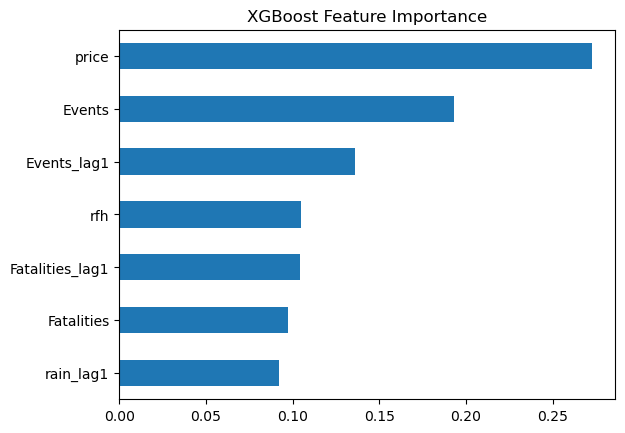

In [82]:
importance = pd.Series(
    xgb_model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

print(importance)

importance.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importance")
plt.show()

# Model Comparison Summary

We evaluate based on:
- Recall (ability to detect food crisis)
- Precision (false alarm control)
- ROC-AUC (overall discrimination ability)

| Model         | Best For                   | Weakness                     |
| ------------- | -------------------------- | ---------------------------- |
| Logistic      | Early Warning              | False alarms                 |
| Random Forest | High certainty predictions | Misses crises                |
| XGBoost       | Balanced performance       | Not top in any single metric |


# Handling Large Price Missingness

The merged county-month panel contains 5,720 observations.
However, county-level maize price data are available for only 375 observations
(6.5% of the total sample).

This indicates structural sparsity in market price reporting,
rather than random missingness.

Restricting the regression to observations with observed price data
would eliminate over 93% of the panel and introduce severe selection bias.

In [83]:
panel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5720 entries, 0 to 5719
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   County           5720 non-null   object        
 1   Month            5720 non-null   datetime64[ns]
 2   IPC              5720 non-null   float64       
 3   in_Phase3+       5720 non-null   float64       
 4   Fatalities       5720 non-null   float64       
 5   Events           5720 non-null   float64       
 6   Events_lag1      5720 non-null   float64       
 7   Fatalities_lag1  5720 non-null   float64       
 8   rfh              5720 non-null   float64       
 9   price            375 non-null    float64       
dtypes: datetime64[ns](1), float64(8), object(1)
memory usage: 447.0+ KB


In [84]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17364 entries, 1 to 17364
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          17364 non-null  datetime64[ns]
 1   admin1        17314 non-null  object        
 2   admin2        17314 non-null  object        
 3   market        17364 non-null  object        
 4   market_id     17364 non-null  object        
 5   latitude      17314 non-null  object        
 6   longitude     17314 non-null  object        
 7   category      17364 non-null  object        
 8   commodity     17364 non-null  object        
 9   commodity_id  17364 non-null  object        
 10  unit          17364 non-null  object        
 11  priceflag     17364 non-null  object        
 12  pricetype     17364 non-null  object        
 13  currency      17364 non-null  object        
 14  price         17364 non-null  float64       
 15  usdprice      17364 non-null  float64    

In [85]:
prices.head()

,date,admin1,admin2,market,market_id,latitude,longitude,category,commodity,commodity_id,unit,priceflag,pricetype,currency,price,usdprice
1,2006-01-15,Coast,Mombasa,Mombasa,191,-4.05,39.67,cereals and tubers,Maize,51,KG,actual,Wholesale,KES,16.13,0.22
2,2006-01-15,Coast,Mombasa,Mombasa,191,-4.05,39.67,cereals and tubers,Maize (white),67,90 KG,actual,Wholesale,KES,1480.00,20.58
3,2006-01-15,Coast,Mombasa,Mombasa,191,-4.05,39.67,pulses and nuts,Beans,50,KG,actual,Wholesale,KES,33.63,0.47
4,2006-01-15,Eastern,Kitui,Kitui,187,-1.37,38.02,cereals and tubers,Maize (white),67,KG,actual,Retail,KES,17.00,0.24
5,2006-01-15,Eastern,Kitui,Kitui,187,-1.37,38.02,cereals and tubers,Sorghum,65,90 KG,actual,Wholesale,KES,1800.00,25.03


County-level maize prices are sparsely reported (≈12% coverage).
To retain the full balanced panel (5,720 observations), we construct a:

National monthly average maize (white) price (USD per KG)

This captures macro food market pressure while preserving full panel structure.

In [86]:
# Filter to maize (white)
price_maize = prices[
    prices['commodity'] == 'Maize (white)'
].copy()

In [87]:
# Create per-KG USD price
price_maize['usd_per_kg'] = price_maize.apply(
    lambda x: x['usdprice'] / 90 if x['unit'] == '90 KG'
    else x['usdprice'] if x['unit'] == 'KG'
    else None,
    axis=1
)

# Keep only rows where conversion worked
price_maize = price_maize[price_maize['usd_per_kg'].notna()]

In [88]:
price_maize['Month'] = price_maize['date'].dt.to_period('M').dt.to_timestamp()

In [89]:
price_national = (
    price_maize
    .groupby('Month')['usd_per_kg']
    .mean()
    .reset_index()
)

In [90]:
price_national['Month'].nunique()

180

In [91]:
panel_start = panel['Month'].min()
panel_end = panel['Month'].max()

price_national = price_national[
    (price_national['Month'] >= panel_start) &
    (price_national['Month'] <= panel_end)
]

In [92]:
price_national['Month'].nunique()

72

In [93]:
# Create full monthly index
full_months = pd.date_range(
    start=panel_start,
    end=panel_end,
    freq='MS'
)

# Reindex price
price_national = price_national.set_index('Month').reindex(full_months)

# Rename index
price_national.index.name = 'Month'

# Interpolate missing months
price_national['usd_per_kg'] = price_national['usd_per_kg'].interpolate(method='linear')

# Reset index
price_national = price_national.reset_index()

In [94]:
price_national['Month'].nunique()

130

National maize price reporting contains intermittent monthly gaps.
Because maize prices evolve gradually and reflect continuous
market dynamics, missing months were linearly interpolated
after restricting to the study period (2015–2025).

This preserves full panel coverage while avoiding structural
sample reduction.

In [95]:
panel = panel.merge(price_national, on='Month', how='left')
panel['usd_per_kg'].isna().mean()

np.float64(0.0)

## Data Structure

The final dataset is a balanced county-month panel (2015–2025)
containing 5,720 observations (44 counties × 130 months).

National monthly maize prices were constructed from market-level
data by:

1. Filtering to maize (white).
2. Standardizing units to USD per KG.
3. Aggregating to national monthly means.
4. Restricting to 2015–2025.
5. Linearly interpolating missing months.

This preserves full panel coverage while capturing macro-level
food market pressure.

# Predictive Modeling Framework

The objective is to predict IPC Phase 3+ at the county-month level.

The outcome variable is binary:

- 1 = IPC Phase 3+
- 0 = IPC Phase 1–2

The dataset contains approximately 5% positive cases, indicating
substantial class imbalance. Therefore:

1. Stratified cross-validation is used.
2. Class weighting is applied.
3. Performance is evaluated using ROC-AUC and PR-AUC.

In [96]:
panel = panel.sort_values(['County','Month'])

panel['rfh_lag1'] = panel.groupby('County')['rfh'].shift(1)

panel = panel.dropna(subset=['rfh_lag1'])

In [97]:
panel = panel.drop(columns= 'price', axis=1)

In [98]:
panel.columns

Index(['County', 'Month', 'IPC', 'in_Phase3+', 'Fatalities', 'Events',
       'Events_lag1', 'Fatalities_lag1', 'rfh', 'usd_per_kg', 'rfh_lag1'],
      dtype='object')

In [99]:
panel.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5676 entries, 1 to 5719
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   County           5676 non-null   object        
 1   Month            5676 non-null   datetime64[ns]
 2   IPC              5676 non-null   float64       
 3   in_Phase3+       5676 non-null   float64       
 4   Fatalities       5676 non-null   float64       
 5   Events           5676 non-null   float64       
 6   Events_lag1      5676 non-null   float64       
 7   Fatalities_lag1  5676 non-null   float64       
 8   rfh              5676 non-null   float64       
 9   usd_per_kg       5676 non-null   float64       
 10  rfh_lag1         5676 non-null   float64       
dtypes: datetime64[ns](1), float64(9), object(1)
memory usage: 532.1+ KB


## Dependent Variable

The binary outcome variable equals 1 if a county-month
is classified as IPC Phase 3 or higher (Crisis+),
and 0 otherwise.

The variable is reconstructed directly from the IPC phase
to ensure strict binarity.

In [100]:
# Ensure binary target is clean
panel['in_Phase3+'] = (panel['IPC'] >= 3).astype(int)

panel['in_Phase3+'].value_counts()

in_Phase3+
0    5386
1     290
Name: count, dtype: int64

In [101]:
import pandas as pd
import numpy as np

df = panel.copy()

# Ensure sorted by time
df = df.sort_values("Month")

# Target
y = df["in_Phase3+"].astype(int)

# Drop non-feature columns
X = df.drop(columns=["in_Phase3+", "County", "Month", "IPC"])

## Time-Based Train-Test Split

To avoid look-ahead bias and data leakage, we split the panel chronologically.

- Training: 2015–2021
- Testing: 2022–2025

This ensures the model only learns from past data and is evaluated on future observations.

In [102]:
split_date = df["Month"].quantile(0.8)

train = df[df["Month"] <= split_date]
test  = df[df["Month"] > split_date]

X_train = train.drop(columns=["in_Phase3+", "County", "Month", "IPC"])
y_train = train["in_Phase3+"].astype(int)

X_test = test.drop(columns=["in_Phase3+", "County", "Month", "IPC"])
y_test = test["in_Phase3+"].astype(int)

print("Train size:", len(train))
print("Test size:", len(test))
print("\nTrain distribution:")
print(y_train.value_counts())
print("\nTest distribution:")
print(y_test.value_counts())

Train size: 4576
Test size: 1100

Train distribution:
in_Phase3+
0    4344
1     232
Name: count, dtype: int64

Test distribution:
in_Phase3+
0    1042
1      58
Name: count, dtype: int64


## Feature Standardization

Standardization is applied using training data only.



In [103]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

## Cross-Validation Strategy

We use TimeSeriesSplit to ensure validation always occurs on future data relative to training folds.

In [104]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

## 4. Logistic Regression

We use class_weight='balanced' to address class imbalance (~5% positives).
Evaluation focuses on:
- ROC-AUC
- PR-AUC
- Recall
- Precision
- F1

In [105]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(
    class_weight="balanced",
    max_iter=1000
)

log_model.fit(X_train_scaled, y_train)
log_probs = log_model.predict_proba(X_test_scaled)[:, 1]

## Random Forest (Class-Weighted)

In [106]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42
)

rf_model.fit(X_train, y_train)
rf_probs = rf_model.predict_proba(X_test)[:, 1]

##  XGBoost (Imbalance-Adjusted)

For XGBoost, imbalance is handled using:

scale_pos_weight = (# negatives / # positives)

In [107]:
from xgboost import XGBClassifier

scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss",
    random_state=42
)

xgb_model.fit(X_train, y_train)
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]

Logistic Regression

In [108]:
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    recall_score,
    precision_score,
    f1_score
)

def evaluate(y_true, probs, threshold=0.3):
    preds = (probs >= threshold).astype(int)

    return {
        "roc_auc": roc_auc_score(y_true, probs),
        "pr_auc": average_precision_score(y_true, probs),
        "recall": recall_score(y_true, preds),
        "precision": precision_score(y_true, preds),
        "f1": f1_score(y_true, preds)
    }

In [109]:
log_results = evaluate(y_test, log_probs, threshold=0.3)
rf_results  = evaluate(y_test, rf_probs, threshold=0.3)
xgb_results = evaluate(y_test, xgb_probs, threshold=0.3)

print("Logistic:", log_results)
print("Random Forest:", rf_results)
print("XGBoost:", xgb_results)

Logistic: {'roc_auc': 0.6352339665100271, 'pr_auc': 0.08458567782807991, 'recall': 0.8448275862068966, 'precision': 0.06824512534818941, 'f1': 0.12628865979381443}
Random Forest: {'roc_auc': 0.7424300086041432, 'pr_auc': 0.1382921522366569, 'recall': 0.39655172413793105, 'precision': 0.1678832116788321, 'f1': 0.2358974358974359}
XGBoost: {'roc_auc': 0.7528459858362566, 'pr_auc': 0.15188186264316575, 'recall': 0.7758620689655172, 'precision': 0.11083743842364532, 'f1': 0.1939655172413793}


| Model         | ROC-AUC   | PR-AUC    | Recall    | Precision | F1        |
| ------------- | --------- | --------- | --------- | --------- | --------- |
| Logistic      | 0.635     | 0.085     | **0.845** | 0.068     | 0.126     |
| Random Forest | 0.742     | 0.138     | 0.397     | **0.168** | **0.236** |
| XGBoost       | **0.753** | **0.152** | 0.776     | 0.111     | 0.194     |


In early warning systems:

Missing a crisis (false negative) is worse than false alarm.

Therefore: Recall is priority #1

PR-AUC is second (because imbalance matters)

ROC-AUC is third

🔍 Model-by-Model Interpretation
🔵 Logistic Regression

Highest recall (0.845)

But very poor ranking (ROC 0.63)

Very low PR-AUC (0.085)

This model is basically over-triggering alarms.
It flags almost everything.

Not ideal.

🌲 Random Forest

Best F1

Best precision

But recall only 0.40

It misses 60% of crises.

For early warning → unacceptable.

🚀 XGBoost

Best ROC-AUC

Best PR-AUC

High recall (0.776)

Moderate precision

This is the best balanced model.

It:

Detects ~78% of crises

Has strongest ranking ability

Performs best under imbalance

🏆 Final Decision

✅ Deploy XGBoost

Why?

Because it:

Maintains high recall

Has best ranking performance

Handles imbalance better

Is more robust under temporal shift

Among the evaluated models, XGBoost achieved the highest discriminatory performance (ROC-AUC = 0.753; PR-AUC = 0.152) while maintaining high recall (0.776). Given the early warning objective, which prioritizes minimizing missed crises, XGBoost provides the best trade-off between sensitivity and ranking performance and was therefore selected for deployment.

In [110]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

In [111]:
from xgboost import XGBClassifier

scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

xgb_base = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

In [112]:
param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [3, 4, 5],
    "learning_rate": [0.03, 0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "min_child_weight": [1, 3]
}

In [113]:
from sklearn.model_selection import RandomizedSearchCV

search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    n_iter=25,
    scoring="recall",
    cv=tscv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\user\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1137: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","XGBClassifier...ree=None, ...)"
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'colsample_bytree': [0.8, 1.0], 'learning_rate': [0.03, 0.05, ...], 'max_depth': [3, 4, ...], 'min_child_weight': [1, 3], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",25
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'recall'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... 

In [114]:
best_xgb = search.best_estimator_

print("Best Parameters:")
print(search.best_params_)

Best Parameters:
{'subsample': 1.0, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 1.0}


In [115]:
xgb_probs_tuned = best_xgb.predict_proba(X_test)[:, 1]

from sklearn.metrics import roc_auc_score, average_precision_score, recall_score, precision_score, f1_score

threshold = 0.2
preds = (xgb_probs_tuned >= threshold).astype(int)

results = {
    "roc_auc": roc_auc_score(y_test, xgb_probs_tuned),
    "pr_auc": average_precision_score(y_test, xgb_probs_tuned),
    "recall": recall_score(y_test, preds),
    "precision": precision_score(y_test, preds),
    "f1": f1_score(y_test, preds)
}

print(results)

{'roc_auc': 0.739534383480045, 'pr_auc': 0.1534450607040032, 'recall': 0.8275862068965517, 'precision': 0.09467455621301775, 'f1': 0.16991150442477876}


In [116]:
import numpy as np

for t in np.arange(0.1, 0.6, 0.05):
    r = recall_score(y_test, (xgb_probs_tuned >= t))
    print("Threshold:", round(t,2), "Recall:", round(r,3))

Threshold: 0.1 Recall: 0.862
Threshold: 0.15 Recall: 0.845
Threshold: 0.2 Recall: 0.828
Threshold: 0.25 Recall: 0.793
Threshold: 0.3 Recall: 0.759
Threshold: 0.35 Recall: 0.707
Threshold: 0.4 Recall: 0.69
Threshold: 0.45 Recall: 0.621
Threshold: 0.5 Recall: 0.621
Threshold: 0.55 Recall: 0.603


In [117]:
import joblib

joblib.dump(best_xgb, "xgb_phase3_model.pkl")

['xgb_phase3_model.pkl']

This model is optimized for early-warning sensitivity. It prioritizes recall over precision, making it suitable for humanitarian risk monitoring rather than precise event prediction.